# kaggle 얼굴인식 하기
- mnist처럼 분류된 레이블을 예측하는식임
- 데이터별 레이블(emotion)값이 정해져 있음
- https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge
- 이미지는 48*48 픽셀

## 1. 준비 및 데이터 불러오기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense, Flatten, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

%matplotlib inline

In [ ]:
#경로
path = "/content/drive/MyDrive/Colab Notebooks/DL/4. 카글(얼굴감정분석)/challenges-in-representation-learning-facial-expression-recognition-challenge/" 

# 데이터 불러오기
train = pd.read_csv(path + "train.csv")
test = pd.read_csv(path + "test.csv")
data = pd.read_csv(path+'icml_face_data.csv')
# icml_face_data 파일에 훈련용, 검증용, 테스트용 데이터가 포함됨

In [ ]:
train.shape, test.shape, data.shape

((28709, 2), (7178, 1), (35887, 3))

data = train + test 의 형태임을 알 수 있음

In [ ]:
data.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


## 2. 데이터프레임에서 데이터 종류와 양 파악
- .unique()
- .value_counts()

In [ ]:
data[' Usage'].unique()

array(['Training', 'PublicTest', 'PrivateTest'], dtype=object)

In [ ]:
data[' Usage'].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name:  Usage, dtype: int64

- test 데이터의 종류
  - publictest : validation용
  - privatetest : 리얼 test용

In [ ]:
len(data['emotion'].unique())

7

분류해야할 수 (레이블 수) 7개!

In [ ]:
data['emotion'].value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

### 데이터 종류별 양 시각화하기
- .value_counts().plot()

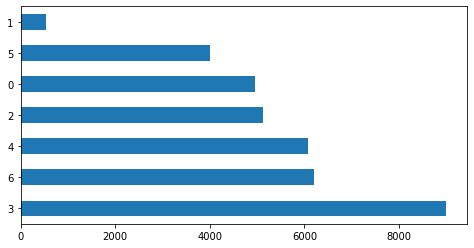

In [ ]:
data['emotion'].value_counts().plot(kind='barh', figsize=(8,4))

빈도 불균형 상태 확인가능 

## 3. 데이터 확인 및 상태 이상 점검

### 이미지 데이터 타입 object(string)에서 정수(int)로 변환

In [ ]:
data[' pixels'][0]

'70 80 82 72 58 58 60 63 54 58 60 48 89 115 121 119 115 110 98 91 84 84 90 99 110 126 143 153 158 171 169 172 169 165 129 110 113 107 95 79 66 62 56 57 61 52 43 41 65 61 58 57 56 69 75 70 65 56 54 105 146 154 151 151 155 155 150 147 147 148 152 158 164 172 177 182 186 189 188 190 188 180 167 116 95 103 97 77 72 62 55 58 54 56 52 44 50 43 54 64 63 71 68 64 52 66 119 156 161 164 163 164 167 168 170 174 175 176 178 179 183 187 190 195 197 198 197 198 195 191 190 145 86 100 90 65 57 60 54 51 41 49 56 47 38 44 63 55 46 52 54 55 83 138 157 158 165 168 172 171 173 176 179 179 180 182 185 187 189 189 192 197 200 199 196 198 200 198 197 177 91 87 96 58 58 59 51 42 37 41 47 45 37 35 36 30 41 47 59 94 141 159 161 161 164 170 171 172 176 178 179 182 183 183 187 189 192 192 194 195 200 200 199 199 200 201 197 193 111 71 108 69 55 61 51 42 43 56 54 44 24 29 31 45 61 72 100 136 150 159 163 162 163 170 172 171 174 177 177 180 187 186 187 189 192 192 194 195 196 197 199 200 201 200 197 201 137 58 98 92

In [ ]:
len(data[' pixels'][0])

8287

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1    Usage   35887 non-null  object
 2    pixels  35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


- 48 * 48 = 2304
- 8287 과 값이 다름!!
  - -> 기존 데이터가 object(string)으로 되어있어서 그렇다! -> 데이터 형태 변환해주어야
    - np.fromstring(대상데이터, 변환타입, 구분기준)
  - **판다스에서는 string을 object라고 표현함!!**

In [ ]:
check = np.fromstring(data[' pixels'][0], dtype=int, sep=' ')
len(check)


2304

In [ ]:
type(check)

numpy.ndarray

In [ ]:
def preprocessing(data):
  
  image = np.zeros(shape =
                   (len(data), 48, 48)
                   ) # 48*48 길이만큼의 빈 넘파이형태를 생성 (이미지가 차지할 공간)

  label = np.array(
      list(map(int, data['emotion']))
      ) # 그냥 데이터에서 y 타겟 데이터를 빼는거뿐이다

  for i, row in enumerate(data.index) :
    df = np.fromstring(data[' pixels'][row], dtype=int, sep=' ') # 모든행의 pixels 값을 int로 변환
    df = np.reshape(df, (48,48)) # 그 후 reshape
    image[i] = df # 처음만들어준 image에 하나씩 넣는다.

  return image, label

### .index : 판다스 문법임. 그냥 한 행씩 보겠다는 의미!
- .index(i) : 이건 i의 위치값 찾는 파이썬 문법.

### .enumerate() : 원소값과 인덱스값까지 같이 컨트롤 할 수 있음
- 그냥써도 되지만 for i,j 이렇게 하면 각 변수에 담아서 조정할 수 있음
- 첫번째가 인덱스, 두번째가 값

In [ ]:
for entry in enumerate(['A', 'B', 'C']) :
  print(entry) # 자동으로 인덱스값과 값을 같이 출력해줌
for i, entry in enumerate(['A', 'B', 'C']) :
  print(i, entry) # 똑같은데 i, entry로 각기 다른 변수로 컨트롤 할 수 있음

(0, 'A')
(1, 'B')
(2, 'C')
0 A
1 B
2 C


In [ ]:
x_train, y_train = preprocessing(data[data[' Usage']=='Training'])
x_val, y_val = preprocessing(data[data[' Usage']=='PrivateTest'])
x_test, y_test = preprocessing(data[data[' Usage']=='PublicTest'])

In [ ]:
x_train.shape, x_val.shape, x_test.shape

((28709, 48, 48), (3589, 48, 48), (3589, 48, 48))

### 데이터 하나 예시로 이미지 확인하기


해당 사진의 감정 상태 : 0


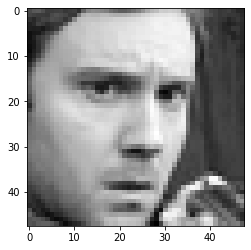

In [ ]:
plt.imshow(x_train[0], cmap='gray')
print("해당 사진의 감정 상태 :",y_train[0])

## 4. 베이스라인 모델 생성
- 모델 층 생성 : .Sequential
- 컴파일 : optimizer, loss 손실함수, metriccs
- 훈련 : model.fit(x_train, y_train, 검증셋(x,y), epochs, batch_size)

### 모델1. 배치정규화 사용 x

In [35]:
# 모델1
model = Sequential([
                    Flatten(input_shape=(48,48)),
                    Dense(128, activation='relu'),
                    Dense(7, activation='softmax')
])
# 모델 컴파일
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 훈련(학습)
history = model.fit(x_train, y_train,  validation_data=(x_val, y_val), epochs=5, batch_size=64) 

Epoch 1/5
449/449 [==============================] - 3s 5ms/step - loss: 18.8376 - accuracy: 0.2376 - val_loss: 1.8830 - val_accuracy: 0.2452
Epoch 2/5
449/449 [==============================] - 2s 5ms/step - loss: 1.8638 - accuracy: 0.2514 - val_loss: 1.8469 - val_accuracy: 0.2449
Epoch 3/5
449/449 [==============================] - 2s 5ms/step - loss: 1.8361 - accuracy: 0.2516 - val_loss: 1.8320 - val_accuracy: 0.2449
Epoch 4/5
449/449 [==============================] - 2s 5ms/step - loss: 1.8237 - accuracy: 0.2516 - val_loss: 1.8248 - val_accuracy: 0.2452
Epoch 5/5
449/449 [==============================] - 2s 5ms/step - loss: 1.8173 - accuracy: 0.2517 - val_loss: 1.8209 - val_accuracy: 0.2452


### 모델2. 배치정규화 사용 o
- 딥러닝에서 사용하는 정규화 방식
- 은닉층 사이사이에 저렇게 사용한다. 별거없음.

In [36]:
# 모델2
model = Sequential([
                    Flatten(input_shape=(48,48)),
                    BatchNormalization(),
                    Dense(128, activation='relu'),
                    BatchNormalization(),
                    Dense(7, activation='softmax')
])
# 모델 컴파일
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 훈련(학습)
history = model.fit(x_train, y_train,  validation_data=(x_val, y_val), epochs=5, batch_size=64) 

Epoch 1/5
449/449 [==============================] - 4s 8ms/step - loss: 1.7056 - accuracy: 0.3402 - val_loss: 1.6207 - val_accuracy: 0.3770
Epoch 2/5
449/449 [==============================] - 3s 8ms/step - loss: 1.5736 - accuracy: 0.3867 - val_loss: 1.5827 - val_accuracy: 0.3853
Epoch 3/5
449/449 [==============================] - 3s 7ms/step - loss: 1.5192 - accuracy: 0.4132 - val_loss: 1.5690 - val_accuracy: 0.3970
Epoch 4/5
449/449 [==============================] - 3s 8ms/step - loss: 1.4780 - accuracy: 0.4296 - val_loss: 1.5319 - val_accuracy: 0.4057
Epoch 5/5
449/449 [==============================] - 3s 8ms/step - loss: 1.4414 - accuracy: 0.4481 - val_loss: 1.5612 - val_accuracy: 0.3851


### test

In [37]:
loss, acc = model.evaluate(x_test, y_test)
print('test정확도:', acc)

113/113 [==============================] - 0s 2ms/step - loss: 1.5760 - accuracy: 0.3934
test정확도: 0.3934243619441986


### 결과 시각화

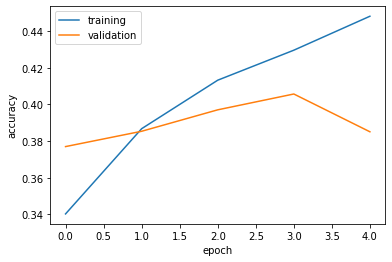

In [38]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['training', 'validation'])

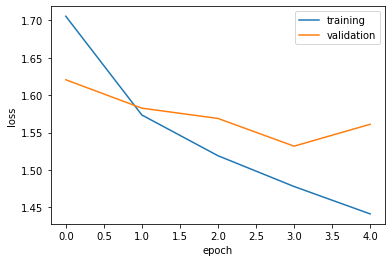

In [39]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'])

## 5. CNN 적용 

In [40]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping

### CNN 시의 전처리 : 색깔 차원 추가 


In [41]:
print(x_train.shape, x_val.shape, x_test.shape)
x_train = x_train.reshape((x_train.shape[0], 48, 48, 1))
x_val = x_val.reshape((x_val.shape[0], 48, 48, 1))
x_test = x_test.reshape((x_test.shape[0], 48, 48, 1))
print(x_train.shape, x_val.shape, x_test.shape)

(28709, 48, 48) (3589, 48, 48) (3589, 48, 48)
(28709, 48, 48, 1) (3589, 48, 48, 1) (3589, 48, 48, 1)


### 0~1 사이로 변경
- 255로 나누는 그 원리

In [42]:
x_train = x_train.astype('float32')/x_train.max()
x_val = x_val.astype('float32')/x_val.max()
x_test = x_test.astype('float32')/x_test.max()

In [43]:
# 모델3 CNN 적용 (한번 돌리면 시간 꽤 소모되니 주의!)
model = Sequential([
                    Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 1)),
                    MaxPooling2D((2, 2)),
                    Conv2D(64, (3, 3), activation='relu'),
                    MaxPooling2D((2, 2)),
                    Flatten(),
                    Dense(128, activation='relu'),
                    Dense(7, activation='softmax')
])
# 모델 컴파일
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=3) # 개선없는지점 만난다고 바로 스톱하는게 아니라 3번은 기회준다

# 훈련(학습)
history = model.fit(x_train, y_train,  validation_data=(x_val, y_val), epochs=30, batch_size=64, callbacks=[early_stopping]) 



Epoch 1/30
449/449 [==============================] - 141s 312ms/step - loss: 1.5775 - accuracy: 0.3859 - val_loss: 1.4219 - val_accuracy: 0.4472
Epoch 2/30
449/449 [==============================] - 138s 307ms/step - loss: 1.3530 - accuracy: 0.4867 - val_loss: 1.3219 - val_accuracy: 0.4915
Epoch 3/30
449/449 [==============================] - 138s 307ms/step - loss: 1.2466 - accuracy: 0.5280 - val_loss: 1.2609 - val_accuracy: 0.5127
Epoch 4/30
449/449 [==============================] - 154s 343ms/step - loss: 1.1566 - accuracy: 0.5651 - val_loss: 1.2167 - val_accuracy: 0.5210
Epoch 5/30
449/449 [==============================] - 137s 305ms/step - loss: 1.0599 - accuracy: 0.6045 - val_loss: 1.2190 - val_accuracy: 0.5311
Epoch 6/30
449/449 [==============================] - 136s 303ms/step - loss: 0.9661 - accuracy: 0.6422 - val_loss: 1.2496 - val_accuracy: 0.5430
Epoch 7/30
449/449 [==============================] - 140s 313ms/step - loss: 0.8692 - accuracy: 0.6813 - val_loss: 1.2348 -

### 결과 시각화 

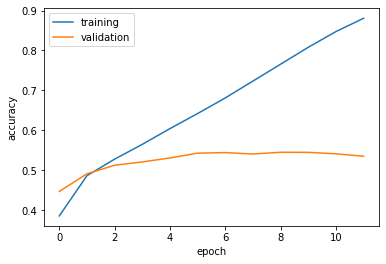

In [44]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['training', 'validation'])

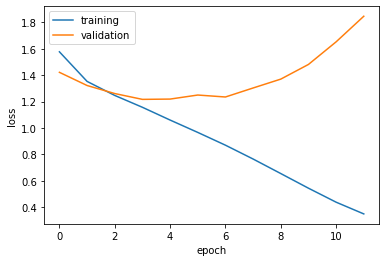

In [45]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'])

### test

In [46]:
loss, acc = model.evaluate(x_test, y_test)
print('test정확도:', acc)

113/113 [==============================] - 4s 37ms/step - loss: 1.9050 - accuracy: 0.5458
test정확도: 0.545834481716156
